In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image  
import time

import torchvision
import torchvision.transforms as transforms
import torchvision.utils
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from utils import toumap, totsne, plotsmart
from utils import getallranks, calcmap
from utils import bestk_silhouette_score, getclusters_ws

from dataset import CustomDataset, DatasetFeatsTrain, dsbuild
from model import netmodel
from loss import HybridLoss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

print('Using device:', torch.cuda.is_available(), torch.cuda.get_device_name(0))

Using device: True NVIDIA RTX A4500


# Feature Extraction

**Pre-traineded models**

In [4]:
netfeat = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14')
netfeat.to(device)
netfeat.eval()

def getfeat(x):
    with torch.no_grad():
        X = netfeat(x)
    return X   

Using cache found in /home/de/.cache/torch/hub/facebookresearch_dinov2_main
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitg14/dinov2_vitg14_pretrain.pth" to /home/de/.cache/torch/hub/checkpoints/dinov2_vitg14_pretrain.pth
100%|██████████| 4.23G/4.23G [02:08<00:00, 35.4MB/s] 


In [6]:
class ConvertTo3Channels:
    def __call__(self, img):
        # Se a imagem já tiver 3 canais, retorne-a como está
        if img.mode == "RGB":
            return img
        # Caso contrário, converta-a para RGB
        return img.convert("RGB")
    
transform = transforms.Compose(
    [
        ConvertTo3Channels(),
        transforms.Resize((224, 224), transforms.InterpolationMode.BICUBIC),
        transforms.ToTensor()
    ]
)

def configfeats(ds):
    with torch.no_grad():
        ds.feats = [[getfeat(d.unsqueeze(0).to(device))[0].cpu(), l] for d, l in ds]

ds = torchvision.datasets.CIFAR10('~/lab/ds',train = True, transform=transform, download=True)
dstest = torchvision.datasets.CIFAR10('~/lab/ds',train = False, transform=transform, download=True)

configfeats(ds)
configfeats(dstest)
len(ds.data)


100%|██████████| 170498071/170498071 [00:09<00:00, 17510404.23it/s]


Extracting /home/de/lab/ds/cifar-10-python.tar.gz to /home/de/lab/ds
Files already downloaded and verified


50000

**OBS: Utilizar CROSS-VALIDATION para DS sem split**

In [ ]:
from sklearn.model_selection import StratifiedKFold

n_folds = 5 # ou seja um quinto (20/80), vai treinar com 20% e validar o resto, mas com todas as partes, retornando 5 resultados, e depois obter uma média
stratified_kfold = StratifiedKFold(n_splits=n_folds, shuffle=True)
x, y = [ d for d,_ in train_dataset], train_dataset.targets

crossidxs = [[idxtrain, idxtest] for idxtrain, idxtest in stratified_kfold.split(x, y)]

imgstrain = [torch.tensor(x[idx]) for idx in crossidxs[0][0]]
lbstrain   = [torch.tensor(y[idx]) for idx in crossidxs[0][0]]

imgstest = [torch.tensor(x[idx]) for idx in crossidxs[0][1]]
lbstest   = [torch.tensor(y[idx]) for idx in crossidxs[0][1]]

ds = CustomDataset(imgstrain, lbstrain, None, train_dataset.classes)
dstest = CustomDataset(imgstest, lbstest, None, train_dataset.classes)

configfeats(ds)
configfeats(dstest)
len(ds.data)


# Clustering and centroid computation

In [ ]:
#xtsne = totsne([f for f, l in ds.feats])
# plotsmart(xtsne, [l for _, l in ds.feats])

**Clustering step**

K score 3 : 0.3593301
K score 4 : 0.33353546
K score 5 : 0.3289464
K score 6 : 0.3611568
K score 7 : 0.37075603
K score 8 : 0.40082583
K score 9 : 0.42240694
K score 10 : 0.44524476
K score 11 : 0.4525927
K score 12 : 0.45051718
K score 13 : 0.44883633
K score 14 : 0.44571665
K score 15 : 0.44094542
K score 16 : 0.4296439
K score 17 : 0.42741218
K score 18 : 0.4256411
K score 19 : 0.4190388
K score 20 : 0.42443052
K score 21 : 0.42098445
K score 22 : 0.4317177
K score 23 : 0.435826
K score 24 : 0.43885174
K score 25 : 0.43212402
K score 26 : 0.43860504
K score 27 : 0.43887496
K score 28 : 0.43806696
K score 29 : 0.434493


/home/de/miniconda3/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


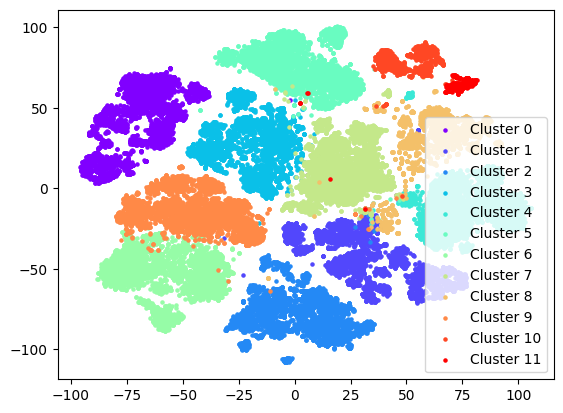

In [14]:
from sklearn.cluster import  AgglomerativeClustering

feats = [f for f,_ in ds.feats]
X = totsne(feats)

sampling_factor = 0.5 # for fast silhouette_score
idxs_sampling = random.sample(range(len(ds.feats)), round(len(ds.feats) * sampling_factor))
xsampling = totsne([feats[i] for i in idxs_sampling])
nclusters = bestk_silhouette_score(xsampling, rangeend=30) #get_nclusters(feats)

agg = AgglomerativeClustering(n_clusters=nclusters)
clusterlbs = agg.fit_predict(toumap(feats))
plotsmart(X, clusterlbs)

# Teacher neural network model

In [15]:
def getpar(ds):
    idxa = random.randint(0, len(ds.feats)-1)
    anchor, cl = ds.feats[idxa]

    is_same_class = random.choice([True, False])
    if is_same_class:
        pairidx = random.choice(ds.lbclassrel[cl.item()])
    else:
        cls = ds.idclasses.copy()
        cls.remove(cl.item())
        pairidx = random.choice(ds.lbclassrel[random.choice(cls)])
        
    pair_img, clp = ds.feats[pairidx]
    #print(cl, clp)
    mgadd = torch.tensor(ds.clusters_ws[cl.item()][clp.item()])
    return anchor, pair_img, torch.tensor(int(not is_same_class)), cl, clp, mgadd

def getbatch(ds, nbatch=32):
    ret = [getpar(ds) for n in range(nbatch)]
    anchors, pars, lbs, albs, plbs, mgs = [], [], [], [], [], []
    for r in ret:
        anchors.append(r[0])
        pars.append(r[1])
        lbs.append(r[2])
        albs.append(r[3])
        plbs.append(r[4])
        mgs.append(r[5])
    # [r[0] for r in ret], [r[1] for r in ret],[r[2] for r in ret]
    return torch.stack(anchors, dim=0), torch.stack(pars, dim=0), torch.stack(lbs, dim=0), torch.stack(albs, dim=0), torch.stack(plbs, dim=0), torch.stack(mgs, dim=0)

In [16]:

class histloss():
    def __init__(self) -> None:
        self.histloss =[]

hloss = histloss()

def treino(model, ds, n_epochs=1000, _margin = 2.0, _batchsize = 128):

    optimizer = optim.AdamW(model.parameters(), lr=0.0014)
    criterion = HybridLoss(margin=_margin)  # ContrastiveLoss(margin=_margin) 

    model.train()
    lossacum = 0

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        ctd = 0
        start = time.time()

        img1, img2, label, lbs1, lbs2, mgadd = getbatch(ds, _batchsize)
        img1, img2, label, lbs1, lbs2, mgadd = img1.to(device), img2.to(device), label.to(device), lbs1.to(device), lbs2.to(device), mgadd.to(device) 
        optimizer.zero_grad()
        
        #img1, img2 = F.normalize(img1, dim=1), F.normalize(img2, dim=1)
        #print(img1.shape)
        _, outlbs1, ored1 = model(img1)     
        _, outlbs2, ored2 = model(img2)

        outlbs = F.log_softmax(torch.cat([outlbs1, outlbs2]), dim=0)
        rotulos = torch.cat([lbs1, lbs2])

        perda_instantanea = criterion(label, outlbs, rotulos, ored1, ored2, mgadd)  
        #perda_instantanea = criteriosmax(outlbs, rotulos) 
        perda_instantanea.backward()
        optimizer.step()

        running_loss += perda_instantanea.item() # loss_contrastive.item()
        lossacum += running_loss                 
        ctd+=1

        if epoch> 0 :  # print every 10 mini-batches
            print('[%d] loss: %.5f' %
                    (epoch + 1, running_loss / ctd), 'time: ' + str(time.time() - start))
            hloss.histloss.append(running_loss / ctd)
            running_loss = 0.0
            ctd = 0

    print('Finished Training')
    ds.training = False
    return n_epochs, lossacum

In [17]:
import time

dstrain = DatasetFeatsTrain([ [f, torch.tensor(l)] for f,l in zip([f for f,_ in ds.feats], clusterlbs)], list(set([l.item() for l in clusterlbs])))
dstrain.clusters_ws = getclusters_ws(feats, clusterlbs)

for idc in dstrain.clusters_ws:
    for idr in dstrain.clusters_ws[idc]:
        dstrain.clusters_ws[idc][idr] = 0

net = netmodel(out_dim=len(dstrain.idclasses)).to(device)

treino(net, dstrain, 1000, _margin=0.5, _batchsize = 2048)

[2] loss: 0.95606 time: 0.4413418769836426
[3] loss: 0.44165 time: 0.44643616676330566
[4] loss: 0.35746 time: 0.43969011306762695
[5] loss: 0.32724 time: 0.44095444679260254
[6] loss: 0.26850 time: 0.4415476322174072
[7] loss: 0.25252 time: 0.4421272277832031
[8] loss: 0.24503 time: 0.44187045097351074
[9] loss: 0.22404 time: 0.44431495666503906
[10] loss: 0.20787 time: 0.4444732666015625
[11] loss: 0.20850 time: 0.4435610771179199
[12] loss: 0.19899 time: 0.4427306652069092
[13] loss: 0.19854 time: 0.4452662467956543
[14] loss: 0.19909 time: 0.44489431381225586
[15] loss: 0.18637 time: 0.4445466995239258
[16] loss: 0.18930 time: 0.44445347785949707
[17] loss: 0.18101 time: 0.44536685943603516
[18] loss: 0.18878 time: 0.4486713409423828
[19] loss: 0.17971 time: 0.4432685375213623
[20] loss: 0.17625 time: 0.4438047409057617
[21] loss: 0.17754 time: 0.44757652282714844
[22] loss: 0.16720 time: 0.44612741470336914
[23] loss: 0.17043 time: 0.44415974617004395
[24] loss: 0.16380 time: 0.44

(1000, 50.97096431069076)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


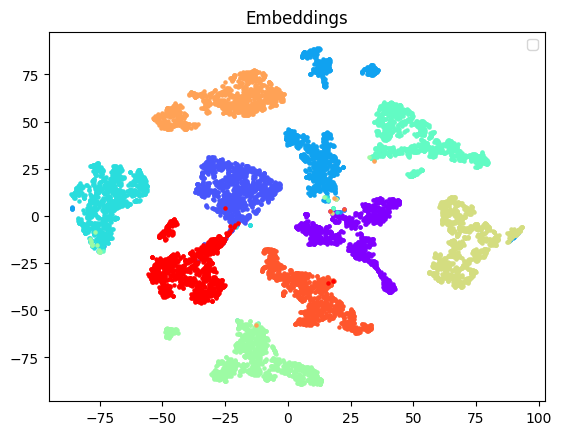

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


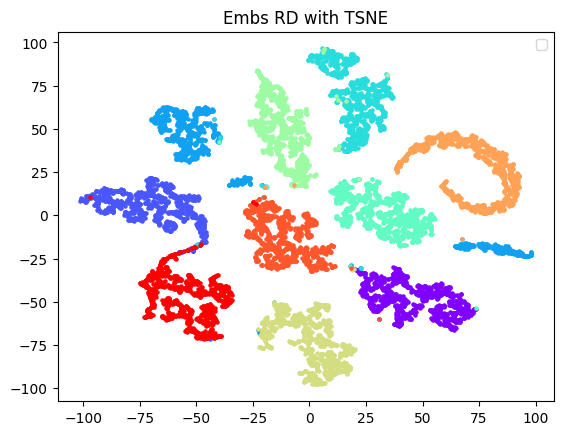

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


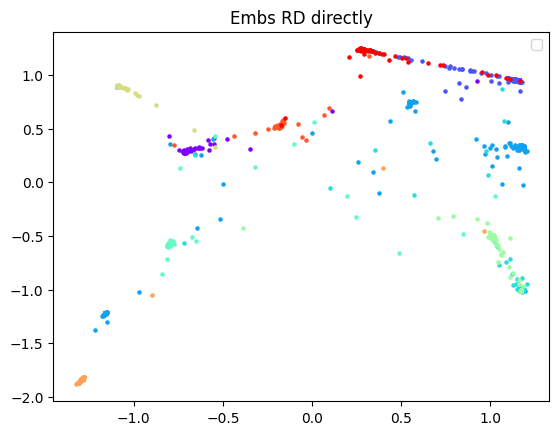

In [18]:
net.eval()
with torch.no_grad():
    fs, lbs = [net(f.to(device).unsqueeze(0)) for f,l in dstest.feats], [l for f,l in dstest.feats]
#.cpu().squeeze()
#plotsmart(totsne( fs), lbs, "", True)
fsembs, fsreduc = [f[0].cpu().squeeze() for f in fs], [f[2].cpu().squeeze() for f in fs]

plotsmart(totsne(fsembs), lbs, "Embeddings", True)
plotsmart(totsne(fsreduc), lbs, "Embs RD with TSNE", True)
plotsmart(np.array(fsreduc), lbs, "Embs RD directly", True)

In [19]:
res = {}

In [20]:
# print()
print("Método proposto sem margem moderada")
ranks = getallranks(fsreduc)
resmap = calcmap(ranks, lbs)
res['ours_not_mg'] = resmap
resmap

Método proposto sem margem moderada


0.9427106087958362

In [22]:
dstrain = DatasetFeatsTrain([ [f, torch.tensor(l)] for f,l in zip([f for f,_ in ds.feats], clusterlbs)], list(set([l.item() for l in clusterlbs])))
dstrain.clusters_ws = getclusters_ws(feats, clusterlbs)

hloss = histloss()
net = netmodel(out_dim=len(dstrain.idclasses)).to(device)

treino(net, dstrain, 1000, _margin=0.5, _batchsize = 2048)

[2] loss: 0.96873 time: 0.4478120803833008
[3] loss: 0.51350 time: 0.4596090316772461
[4] loss: 0.42977 time: 0.4484751224517822
[5] loss: 0.34399 time: 0.4568326473236084
[6] loss: 0.30209 time: 0.473391056060791
[7] loss: 0.27735 time: 0.467909574508667
[8] loss: 0.28111 time: 0.4452400207519531
[9] loss: 0.29134 time: 0.46445751190185547
[10] loss: 0.30695 time: 0.448319673538208
[11] loss: 0.29153 time: 0.4492363929748535
[12] loss: 0.28342 time: 0.44608402252197266
[13] loss: 0.24585 time: 0.4505305290222168
[14] loss: 0.24895 time: 0.4604918956756592
[15] loss: 0.23117 time: 0.44829392433166504
[16] loss: 0.23748 time: 0.4694023132324219
[17] loss: 0.24581 time: 0.44811272621154785
[18] loss: 0.23130 time: 0.4626786708831787
[19] loss: 0.21789 time: 0.45189762115478516
[20] loss: 0.21551 time: 0.4509615898132324
[21] loss: 0.22111 time: 0.44970059394836426
[22] loss: 0.21630 time: 0.4534180164337158
[23] loss: 0.21482 time: 0.46605491638183594
[24] loss: 0.21259 time: 0.477596282

(1000, 65.18342610945597)

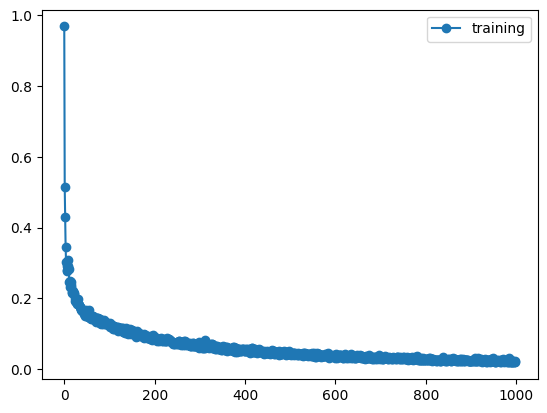

In [23]:
plt.plot(hloss.histloss, 'o-', label='training')
plt.legend()
plt.show()

#validafeats(net, device, [ f for f, _ in ds.feats], [ l for _, l in ds.feats])
#validafeats(net, device, [f for f, _ in dstest.feats], [ l for _, l in dstest.feats])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


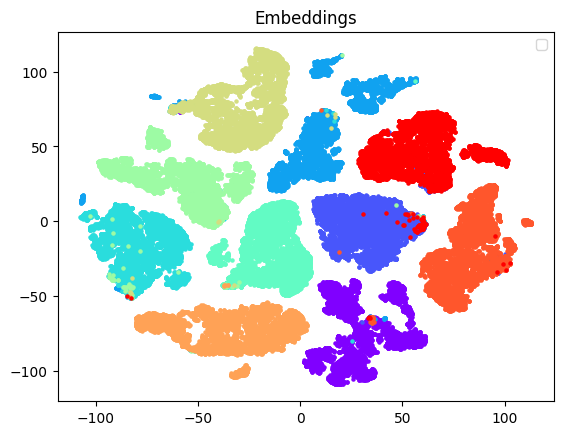

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


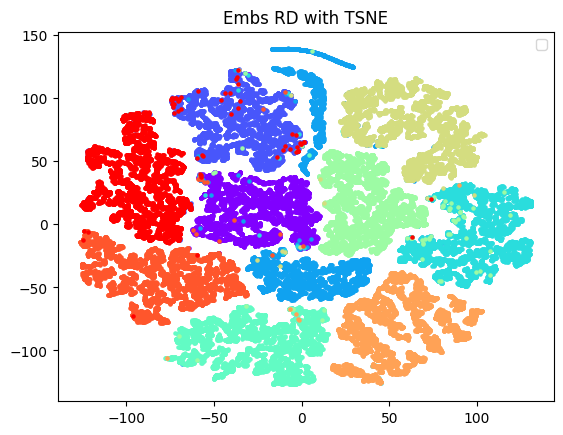

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


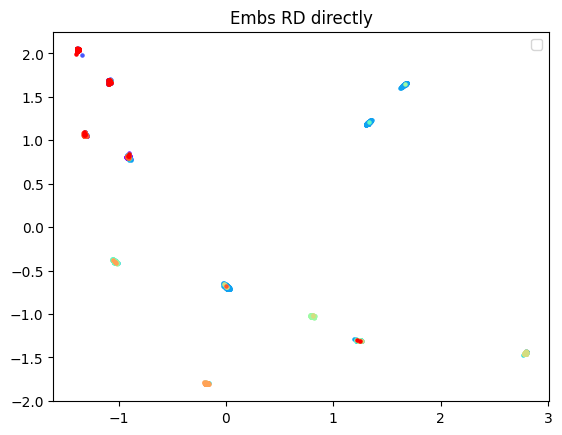

In [24]:
net.eval()
with torch.no_grad():
    trainfs, lbs = [net(f.to("cuda").unsqueeze(0)) for f,l in ds.feats], [l for f,l in ds.feats]
#.cpu().squeeze()
#plotsmart(totsne( fs), lbs, "", True)
trainfsembs, trainfsreduc = [f[0].cpu().squeeze() for f in trainfs], [f[2].cpu().squeeze() for f in trainfs]

plotsmart(totsne(trainfsembs), lbs, "Embeddings", True)
plotsmart(totsne(trainfsreduc), lbs, "Embs RD with TSNE", True)
plotsmart(np.array(trainfsreduc), lbs, "Embs RD directly", True)

**TEST Set**

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


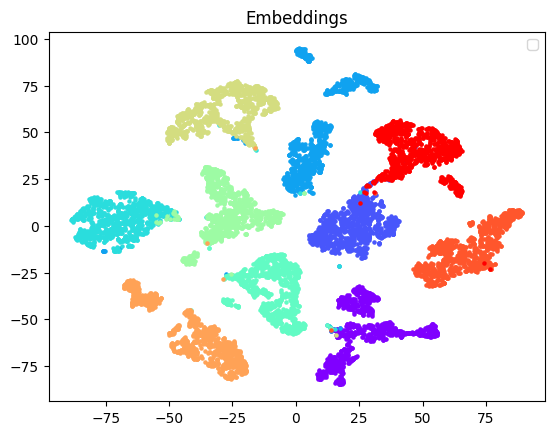

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


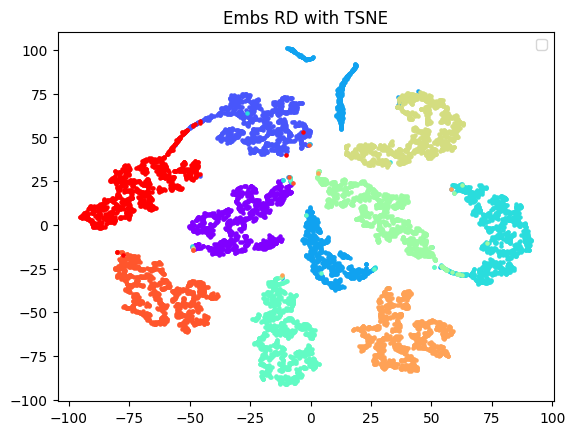

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


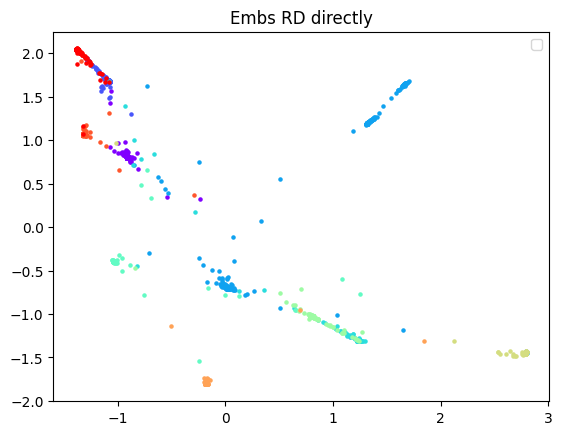

In [25]:
net.eval()
with torch.no_grad():
    fs, lbs = [net(f.to("cuda").unsqueeze(0)) for f,l in dstest.feats], [l for f,l in dstest.feats]
#.cpu().squeeze()
#plotsmart(totsne( fs), lbs, "", True)
fsembs, fsreduc = [f[0].cpu().squeeze() for f in fs], [f[2].cpu().squeeze() for f in fs]

plotsmart(totsne(fsembs), lbs, "Embeddings", True)
plotsmart(totsne(fsreduc), lbs, "Embs RD with TSNE", True)
plotsmart(np.array(fsreduc), lbs, "Embs RD directly", True)

In [26]:
# print()
print("Método proposto")
ranks = getallranks(fsreduc)
resmap = calcmap(ranks, lbs)
res['ours_with_mg'] = resmap
resmap

Método proposto


0.9487446952454905

In [34]:
print("Método proposto High Dim")
ranks = getallranks(fsembs)
resmap = calcmap(ranks, lbs)
res['ours_with_mg_highdim'] = resmap
resmap

Método proposto High Dim


0.9516742381429733

In [35]:
print("Sem projeção")
X = [f for f,l in dstest.feats]
ranks = getallranks(X)
resmap = calcmap(ranks, lbs)
res['no_projection'] = resmap
resmap

Sem projeção


0.6466318360012024

In [41]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

print("PCA")
X = [f for f,l in dstest.feats]
X_pca = pca.fit_transform(X)
ranks = getallranks(torch.tensor(X_pca))
resmap = calcmap(ranks, lbs)
res['pca'] = resmap
resmap

PCA


0.5512483995115917

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


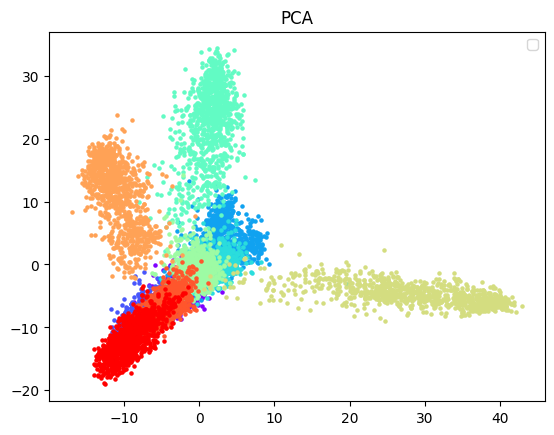

In [40]:
plotsmart(X_pca, lbs, "PCA", True)

In [36]:
print("T-SNE")
X = [f for f,l in dstest.feats]
ranks = getallranks(torch.tensor(totsne(X)))
resmap = calcmap(ranks, lbs)
res['tsne'] = resmap
resmap

T-SNE


0.8574220171839588

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


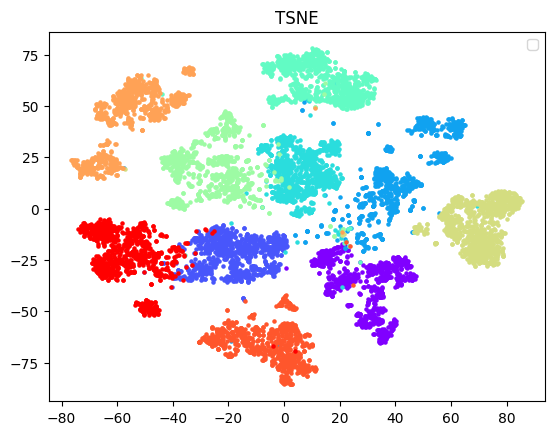

In [37]:
plotsmart(totsne(X), lbs, "TSNE", True)

In [32]:
print("UMAP")
X = [f for f,l in dstest.feats]
ranks = getallranks(torch.tensor(toumap(X)))
resmap = calcmap(ranks, lbs)
res['umap'] = resmap
resmap

UMAP


/home/de/miniconda3/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


0.9111241964306531

/home/de/miniconda3/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


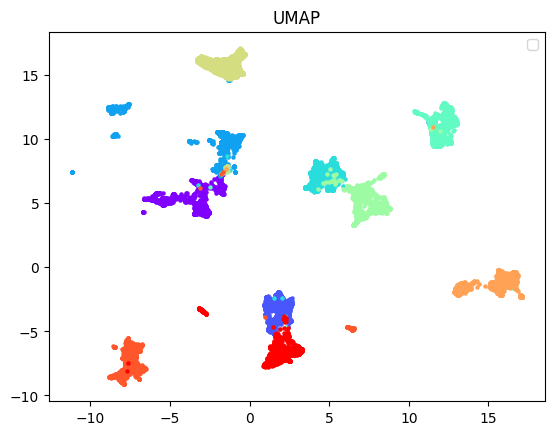

In [33]:
plotsmart(toumap(X), lbs, "UMAP", True)

In [42]:
res

{'ours_not_mg': 0.9427106087958362,
 'ours_not_mg_highdim': 0.9609239611006732,
 'ours_with_mg': 0.9487446952454905,
 'umap': 0.9111241964306531,
 'ours_with_mg_highdim': 0.9516742381429733,
 'no_projection': 0.6466318360012024,
 'tsne': 0.8574220171839588,
 'pca': 0.5512483995115917}